<a href="https://colab.research.google.com/github/saralathanga/5m-data-entry-test/blob/main/DSAI_3_6_Prophet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting With Prophet in Python

This tutorial is based on the Machine Learning Mastery tutorial:
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

It covers:
1. Loading and exploring the monthly car sales dataset
2. Fitting a Prophet model
3. Making in-sample and out-of-sample forecasts
4. Evaluating the model performance

# Time Series Forecasting With Prophet

This tutorial demonstrates how to use Facebook's Prophet for time series forecasting.
We'll use the monthly car sales dataset to demonstrate the key features of Prophet.

In [2]:
# Install required packages (uncomment if needed)
!pip install prophet pandas numpy matplotlib

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Prepare the Dataset

We'll use the monthly car sales dataset from the Machine Learning Mastery tutorial.
This dataset contains 108 months of car sales data with both trend and seasonality.

In [4]:
# Load the monthly car sales dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(url, header=0)

# Display the first few rows
print(df.head())

     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


In [5]:
# Check the data type for df.Month
# Check if df.Month is a date object
print(f"Data type of df.Month: {df.Month.dtype}")
print(f"Is df.Month a datetime object? {pd.api.types.is_datetime64_any_dtype(df.Month)}")
df.head()

Data type of df.Month: object
Is df.Month a datetime object? False


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


## 2. Explore the Dataset

Let's take a look at the basic statistics and plot the time series.

In [6]:
# Display basic statistics
print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB

Descriptive Statistics:
              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000


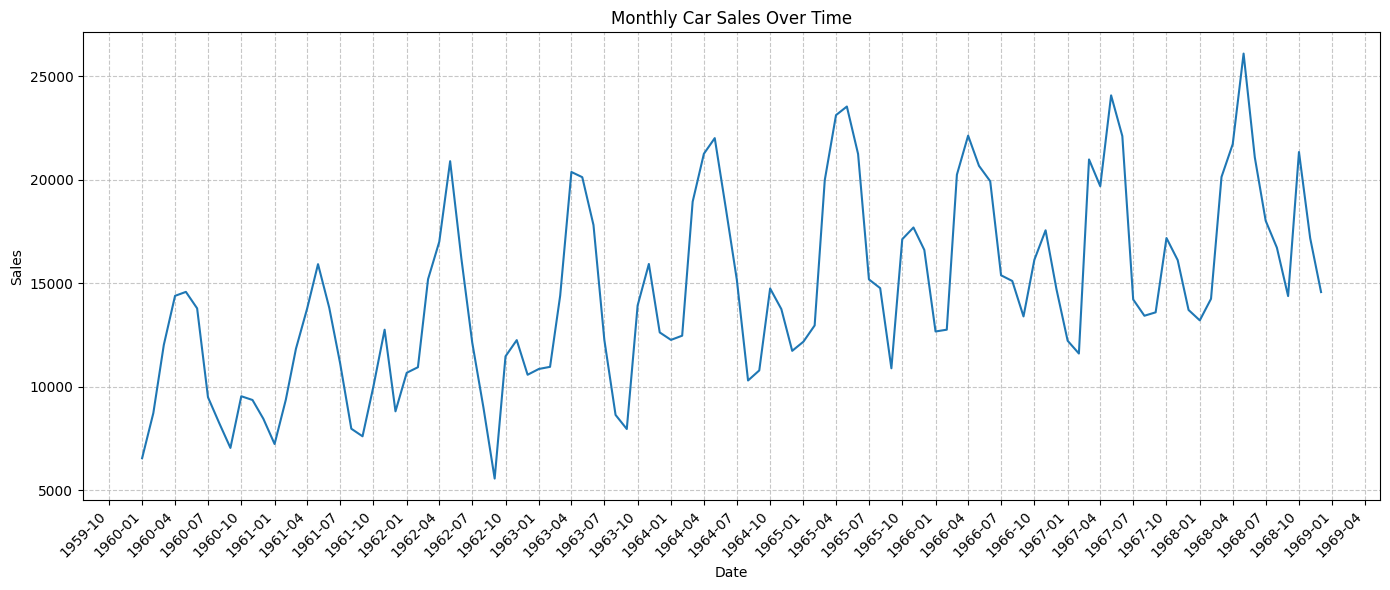

In [7]:
# Plot the time series with monthly ticks
plt.figure(figsize=(14, 6))

# Create a temporary datetime index for plotting
plot_dates = pd.to_datetime(df['Month'])

plt.plot(plot_dates, df['Sales'])
plt.title('Monthly Car Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Configure x-axis to show every 3 months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

# Rotate and adjust x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3. Prepare Data for Prophet

Prophet requires the input dataframe to have two columns:
- ds: The date column (must be datetime)
- y: The target variable (numeric)

In [8]:
# Rename columns for Prophet
df_prophet = df.rename(columns={'Month': 'ds', 'Sales': 'y'})

# Convert date column to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Display the prepared dataframe
print("\nPrepared DataFrame for Prophet:")
print(df_prophet.head())


Prepared DataFrame for Prophet:
          ds      y
0 1960-01-01   6550
1 1960-02-01   8728
2 1960-03-01  12026
3 1960-04-01  14395
4 1960-05-01  14587


## 4. Split into Train and Test Sets

We'll use the first periods of data for training and the remaining 12 periods for testing.

Training set: 96 months (1960-01-01 00:00:00 to 1967-12-01 00:00:00)
Test set: 12 months (1968-01-01 00:00:00 to 1968-12-01 00:00:00)


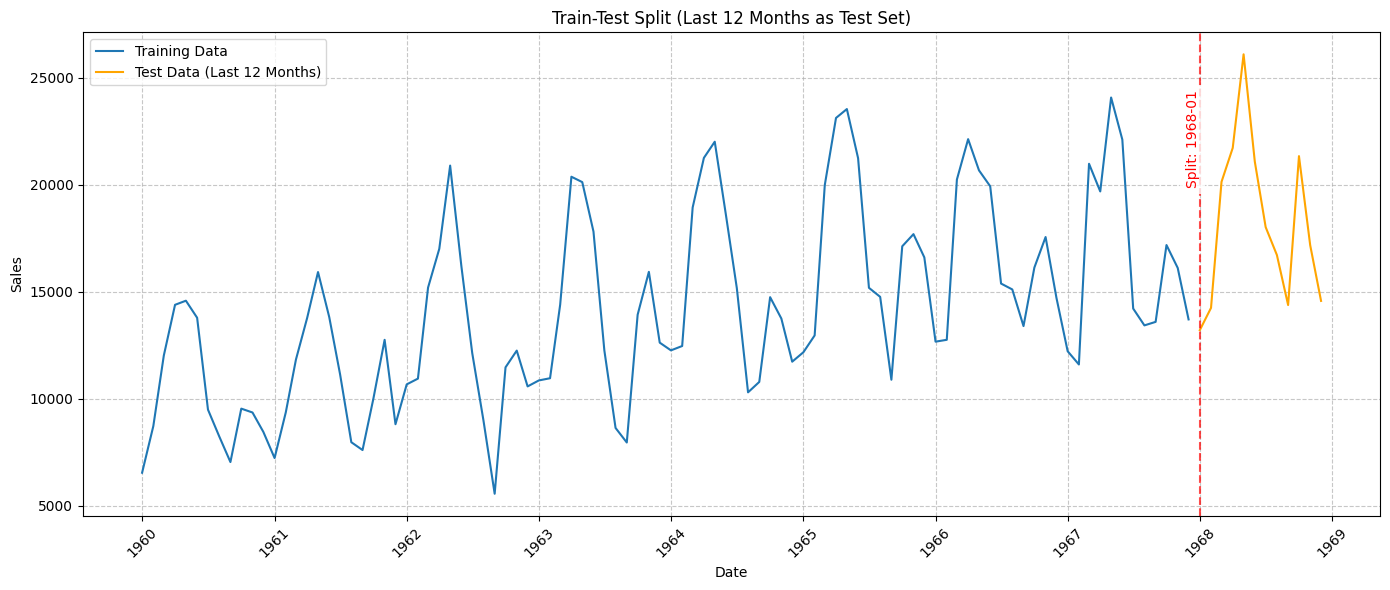

In [9]:
# Split data: last 12 months as test set
test_size = 12
train = df_prophet.iloc[:-test_size]
test = df_prophet.iloc[-test_size:]

print(f"Training set: {len(train)} months ({train['ds'].iloc[0]} to {train['ds'].iloc[-1]})")
print(f"Test set: {len(test)} months ({test['ds'].iloc[0]} to {test['ds'].iloc[-1]})")

# Plot train-test split
plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data (Last 12 Months)', color='orange')

# Add a vertical line to show the split point
split_date = test['ds'].iloc[0]
plt.axvline(x=split_date, color='red', linestyle='--', alpha=0.7)
plt.text(split_date, plt.ylim()[1]*0.9, f'Split: {split_date.strftime("%Y-%m")}',
         color='red', ha='right', va='top', rotation=90,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.title('Train-Test Split (Last 12 Months as Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Fit the Prophet Model

Now we'll create and fit a Prophet model to our training data.

In [10]:
# Initialize and fit the model
model = Prophet(
    yearly_seasonality='auto',  # Capture yearly seasonality
    weekly_seasonality='auto',  # No weekly seasonality in monthly data
    daily_seasonality='auto',   # No daily seasonality in monthly data
    seasonality_mode='additive'  # Additive seasonality
)

# Fit the model
model.fit(train)
print("Model fitting complete")

# Display model information
print("Model components:", model.component_modes)
print("\nSeasonality modes:")
for name, props in model.seasonalities.items():
    print(f"- {name}: {props}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr0pywemv/x7sqiq3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr0pywemv/f669f85t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24876', 'data', 'file=/tmp/tmpr0pywemv/x7sqiq3g.json', 'init=/tmp/tmpr0pywemv/f669f85t.json', 'output', 'file=/tmp/tmpr0pywemv/prophet_model17dhdzal/prophet_model-20250702043803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:38:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:38:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model fitting complete
Model components: {'additive': ['yearly', 'additive_terms', 'extra_regressors_additive', 'holidays'], 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

Seasonality modes:
- yearly: {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}


## 6. In-Sample Evaluation

First, let's evaluate the model on the training data to understand its fit.


In-sample performance metrics (Training Data):
- MAE: 982.35
- MSE: 1446840.57
- RMSE: 1202.85
- MAPE: 7.54%


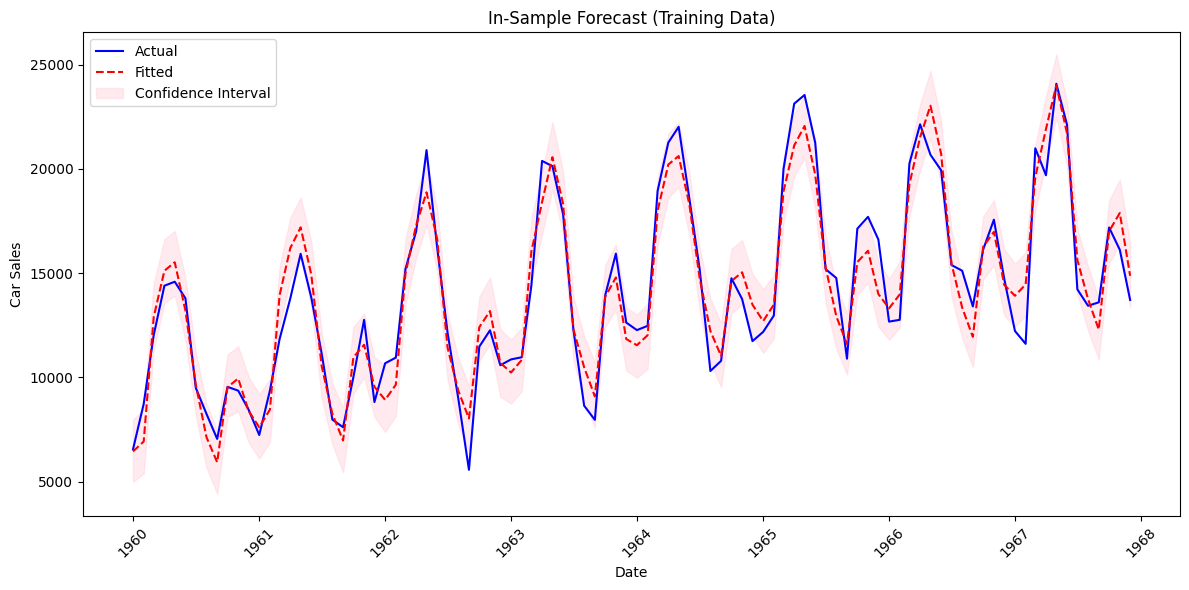

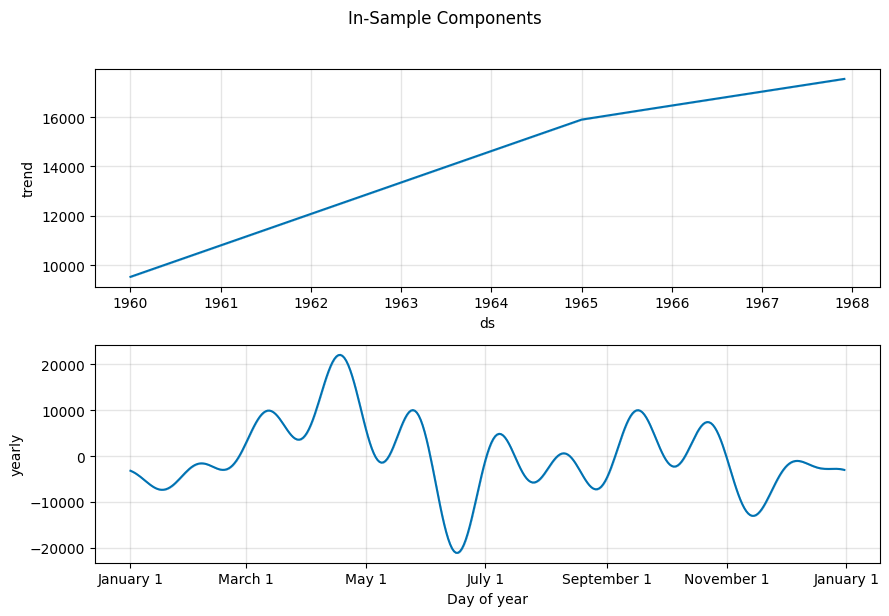

In [11]:
# Make predictions on the training data (in-sample)
train_forecast = model.predict(train)

# Calculate in-sample metrics
train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
train_mse = mean_squared_error(train['y'], train_forecast['yhat'])
train_rmse = np.sqrt(train_mse)
train_mape = np.mean(np.abs((train['y'] - train_forecast['yhat']) / train['y'])) * 100

print("\nIn-sample performance metrics (Training Data):")
print(f"- MAE: {train_mae:.2f}")
print(f"- MSE: {train_mse:.2f}")
print(f"- RMSE: {train_rmse:.2f}")
print(f"- MAPE: {train_mape:.2f}%")

# Plot in-sample forecast
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], 'b-', label='Actual')
plt.plot(train['ds'], train_forecast['yhat'], 'r--', label='Fitted')
plt.fill_between(
    train['ds'],
    train_forecast['yhat_lower'],
    train_forecast['yhat_upper'],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('In-Sample Forecast (Training Data)')
plt.xlabel('Date')
plt.ylabel('Car Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot components for training data
try:
    fig_components = model.plot_components(train_forecast)
    plt.suptitle('In-Sample Components', y=1.02)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting components: {e}")

## 7. Out-of-Sample Forecast

Now, let's make predictions on the test data that the model hasn't seen before.

Test set date range: 1968-01-01 00:00:00 to 1968-12-01 00:00:00
Forecast date range: 1968-01-01 00:00:00 to 1968-12-01 00:00:00

Out-of-sample performance metrics (Test Data):
- MAE: 1336.81
- MSE: 3059644.16
- RMSE: 1749.18
- MAPE: 7.19%


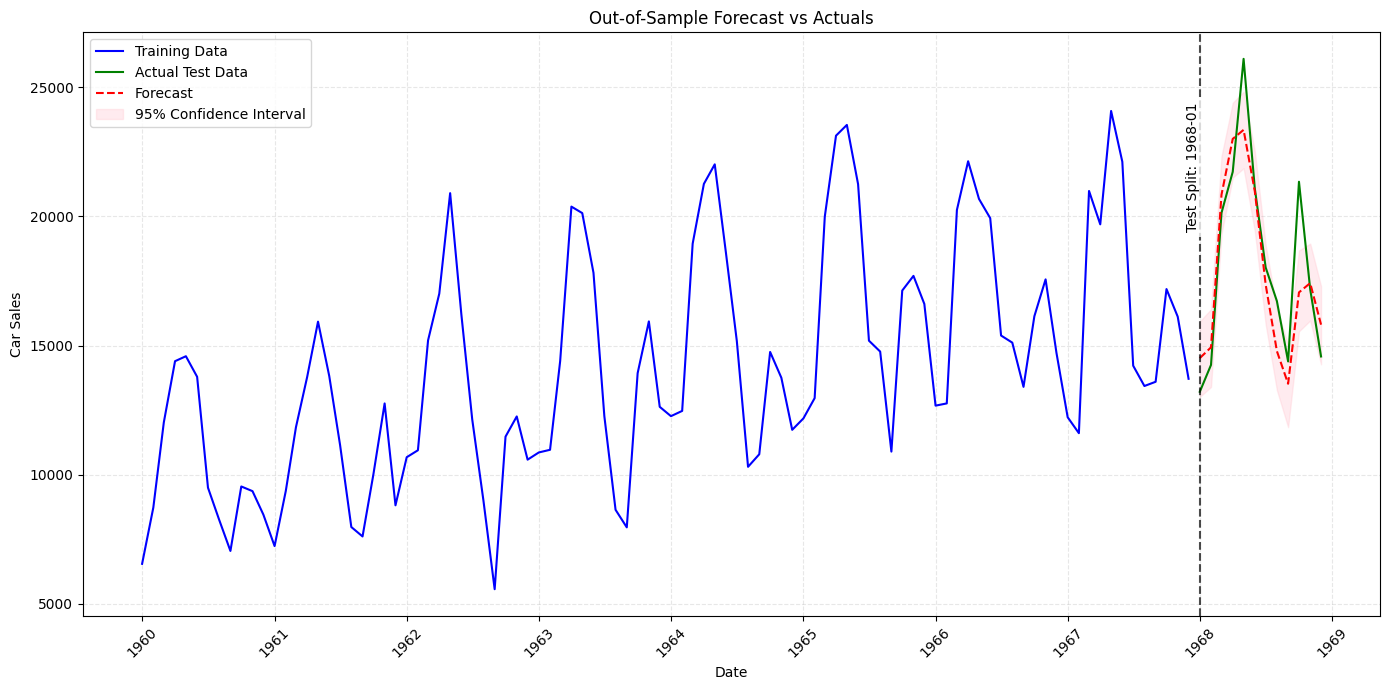

In [12]:
# Create a dataframe with the exact test dates for prediction
future = pd.DataFrame({'ds': test['ds']})

# Make predictions for the test period
forecast = model.predict(future)

# Verify the alignment
if len(forecast) != len(test):
    raise ValueError(f"Mismatch in forecast length: expected {len(test)}, got {len(forecast)}")

# Ensure the dates match exactly
if not all(test['ds'].values == forecast['ds'].values):
    print("Test dates:", test['ds'].values)
    print("Forecast dates:", forecast['ds'].values)
    raise ValueError("Date mismatch between test set and forecast")

# Print date ranges for verification
print(f"Test set date range: {test['ds'].min()} to {test['ds'].max()}")
print(f"Forecast date range: {forecast['ds'].min()} to {forecast['ds'].max()}")

# Ensure we're working with numpy arrays of the same length and order
y_true = test['y'].values
y_pred = forecast['yhat'].values

# Calculate MAPE
test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nOut-of-sample performance metrics (Test Data):")
print(f"- MAE: {mean_absolute_error(test['y'], forecast['yhat']):.2f}")
print(f"- MSE: {mean_squared_error(test['y'], forecast['yhat']):.2f}")
print(f"- RMSE: {np.sqrt(mean_squared_error(test['y'], forecast['yhat'])):.2f}")
print(f"- MAPE: {test_mape:.2f}%")

# Plot the complete forecast with training and test data
plt.figure(figsize=(14, 7))

# Plot training data and forecast
plt.plot(train['ds'], train['y'], 'b-', label='Training Data')
plt.plot(test['ds'], test['y'], 'g-', label='Actual Test Data')
plt.plot(forecast['ds'], forecast['yhat'], 'r--', label='Forecast')

# Add confidence interval
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Add vertical line at train-test split
plt.axvline(x=test['ds'].iloc[0], color='k', linestyle='--', alpha=0.7)
plt.text(
    test['ds'].iloc[0],
    plt.ylim()[1]*0.9,
    f'Test Split: {test["ds"].iloc[0].strftime("%Y-%m")}',
    color='k',
    ha='right',
    va='top',
    rotation=90,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

plt.title('Out-of-Sample Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Car Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Visualize the Forecast Components

Let's look at the trend and seasonality components of the forecast.

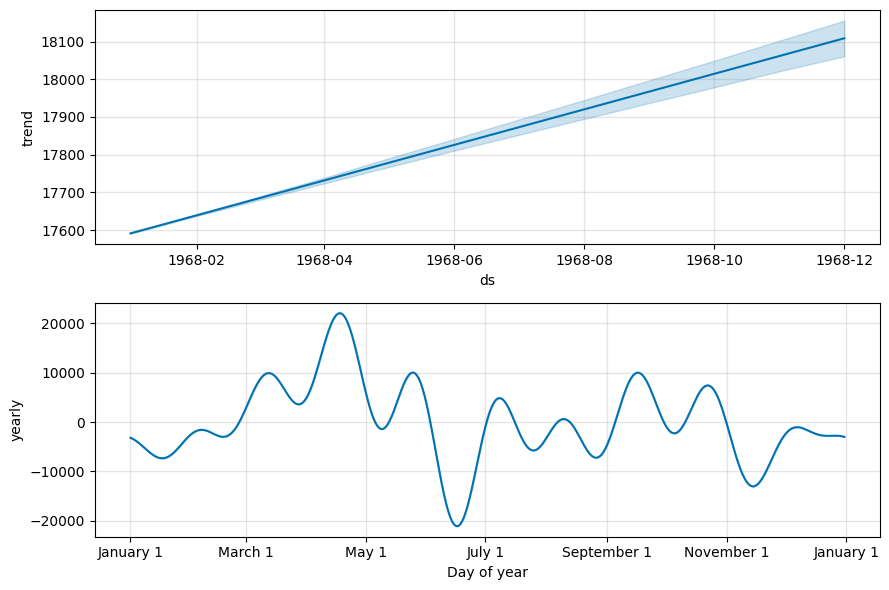

In [13]:
# Plot the forecast components
try:
    fig_components = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting components: {e}")

## Conclusion

This tutorial demonstrated how to use Facebook's Prophet for time series forecasting with Python.
We covered:
1. Loading and preparing time series data
2. Training a Prophet model
3. Making in-sample and out-of-sample forecasts
4. Evaluating forecast accuracy
5. Visualizing the results

Prophet provides a powerful and flexible framework for time series forecasting
with minimal configuration required.

print("\nProphet tutorial completed successfully!")